In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, 
                             average_precision_score, roc_auc_score)
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

In [ ]:
# Загрузка датасета
df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome'] # целевая переменная: диабет присутствует или отсутствует
features = X.columns.tolist()

print(f'Размер датасета: {df.shape[0]} x {df.shape[1]}')
print(df.head())

Размер датасета: 768 x 9
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [6]:
print(df.describe().round(2))

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   768.00         768.00         768.00   768.00  768.00   
mean          3.85   120.89          69.11          20.54    79.80   31.99   
std           3.37    31.97          19.36          15.95   115.24    7.88   
min           0.00     0.00           0.00           0.00     0.00    0.00   
25%           1.00    99.00          62.00           0.00     0.00   27.30   
50%           3.00   117.00          72.00          23.00    30.50   32.00   
75%           6.00   140.25          80.00          32.00   127.25   36.60   
max          17.00   199.00         122.00          99.00   846.00   67.10   

       DiabetesPedigreeFunction     Age  Outcome  
count                    768.00  768.00   768.00  
mean                       0.47   33.24     0.35  
std                        0.33   11.76     0.48  
min                        0.08   21.00     0.00  
25%                        0.24   24.00   

In [ ]:
print(f'Признаки: {features}')

Признаки: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [ ]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler() # масштабирование признаков
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}')
print(f'Test: {X_test_scaled.shape}')

Train: (614, 8)
Test: (154, 8)


- - - - - - - -
**Задание №1:**

Решить задачу классификации  больных методом логистической регрессии и решающих деревьев, используя стандартные настройки моделей.

Вывести стандартные метрики. 

Сделать вывод на основе анализа метрик о том, какая из рассмотренных моделей более подходит для исследуемого датасета.

In [ ]:
def evaluation(model, model_name, X_train, X_test, y_train, y_test):
   
    model.fit(X_train, y_train) # обучение
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba) # ROC-AUC
    else:
        y_test_proba = None
        roc_auc = None
    metrics = {
        'Модель': model_name,
        'Accuracy (train)': accuracy_score(y_train, y_train_predict),
        'Accuracy (test)': accuracy_score(y_test, y_test_predict),
        'Precision (test)': precision_score(y_test, y_test_predict),
        'Recall (test)': recall_score(y_test, y_test_predict),
        'F1-score (test)': f1_score(y_test, y_test_predict),
        'ROC-AUC': roc_auc
    }
    cm = confusion_matrix(y_test, y_test_predict)
    
    return metrics, cm, model

In [ ]:
# Логистическая регрессия
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_metrics, log_cm, log_model = evaluation(log_reg, 'Логистическая регрессия', X_train_scaled, X_test_scaled, y_train, y_test)

# Решающее дерево
tree = DecisionTreeClassifier(random_state=42)
tree_metrics, tree_cm, tree_model = evaluation(tree, 'Решающее дерево', X_train, X_test, y_train, y_test)

metrics_df = pd.DataFrame([log_metrics, tree_metrics])
print(metrics_df.round(4).to_string(index=False))

                 Модель  Accuracy (train)  Accuracy (test)  Precision (test)  Recall (test)  F1-score (test)  ROC-AUC
Логистическая регрессия            0.7915           0.7143            0.6087         0.5185           0.5600    0.823
        Решающее дерево            1.0000           0.7273            0.6429         0.5000           0.5625    0.675


In [ ]:
gap_log = log_metrics['Accuracy (train)'] - log_metrics['Accuracy (test)']
print(f'Разрыв между test и train для логистической регрессии: {gap_log}')

gap_tree = tree_metrics['Accuracy (train)'] - tree_metrics['Accuracy (test)']
print(f'Разрыв между test и train для решающего дерева: {gap_tree}')

Разрыв между test и train для логистической регрессии: 0.07724523033969288
Разрыв между test и train для решающего дерева: 0.2727272727272727


**Вывод:** Решающее дерево со стандартными настройками обладает большим разрывом, чем логистическая регрессия. Точность 1 на обучающей выборке показывает, что решающее дерево может быть переобучено. Хотя его точность на тестовой выборке оказалась выше, чем у логистической регрессии, логистическая регрессия показала более хороший результат по метрике ROC-AUC.

Решающее дерево подходит для решения задачи хуже, чем логистическая регрессия.

- - - - - - - -
**Задание №2:**

Исследовать значение выбранной самостоятельно метрики (выбор обосновать) в зависимости от глубины решающего дерева. 

Построить график зависимости.

**Пояснение:** Важно обратить внимание на TP, так как отсутствие лечения у больного диабетом может привести к его смерти => важно выявить всех больных. Необходимо минимизировать FN. Ошибка FP тоже опасна, так как лечение диабета дорогое и может навредить здоровому человеку.

Метрика **ROC-AUC**: Позволила сделать вывод в прошлом пункте; показывает устойчивость к дисбалансу классов.

In [18]:
# ROC-AUC: зависимость от глубины решающего дерева
max_depths = range(1, 21)
train_auc_scores = []
test_auc_scores = []
cv_auc_scores = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train) # обучение
    y_train_proba = tree.predict_proba(X_train)[:, 1]
    y_test_proba = tree.predict_proba(X_test)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    cv_auc = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc').mean() # кросс-валидация
    train_auc_scores.append(train_auc)
    test_auc_scores.append(test_auc)
    cv_auc_scores.append(cv_auc)

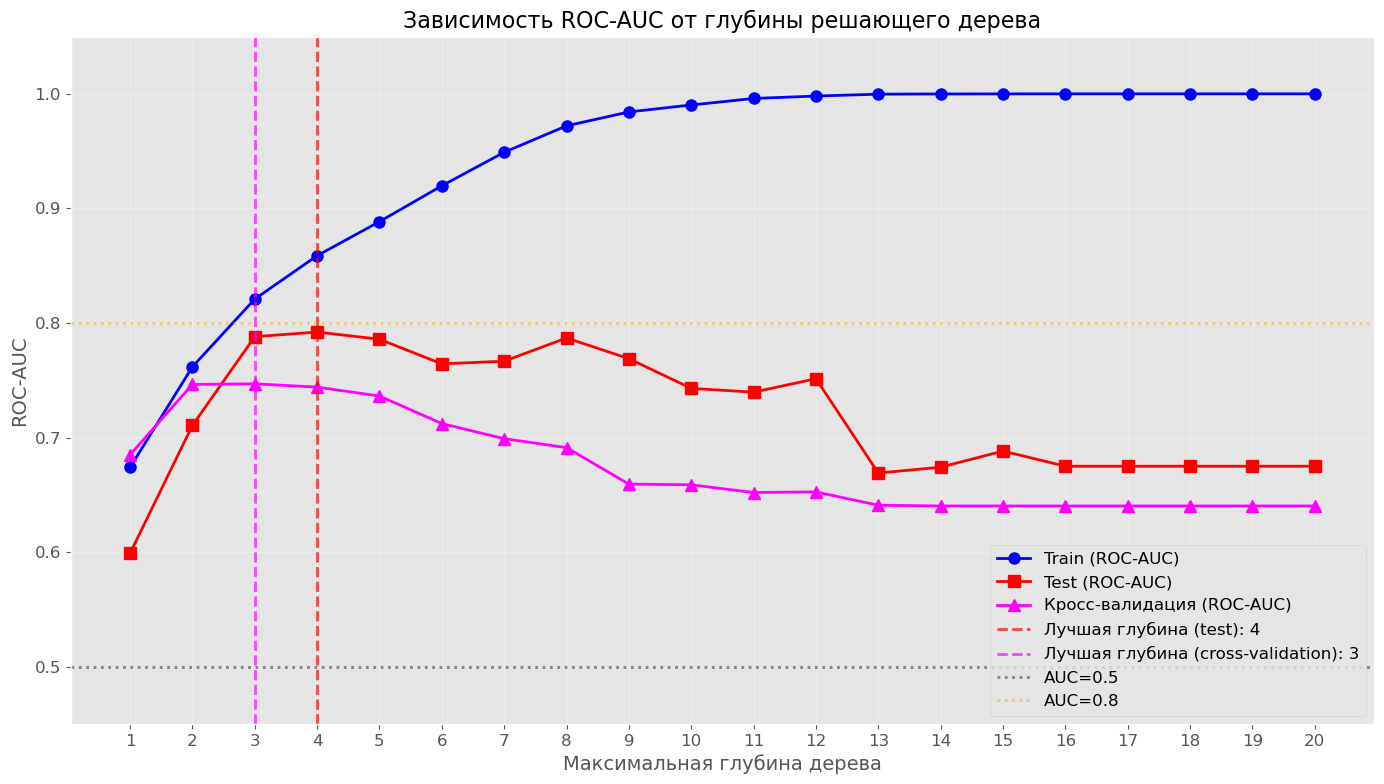

In [19]:
plt.figure(figsize=(14, 8))
plt.plot(max_depths, train_auc_scores, 'o-', linewidth=2, label='Train (ROC-AUC)', color='blue', markersize=8)
plt.plot(max_depths, test_auc_scores, 's-', linewidth=2, label='Test (ROC-AUC)', color='red', markersize=8)
plt.plot(max_depths, cv_auc_scores, '^-', linewidth=2, label='Кросс-валидация (ROC-AUC)', color='magenta', markersize=8)

best_depth_test = max_depths[np.argmax(test_auc_scores)]
best_depth_cv = max_depths[np.argmax(cv_auc_scores)]

plt.axvline(x=best_depth_test, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Лучшая глубина (test): {best_depth_test}')
plt.axvline(x=best_depth_cv, color='magenta', linestyle='--', alpha=0.7, linewidth=2, label=f'Лучшая глубина (cross-validation): {best_depth_cv}')

plt.axhline(y=0.5, color='gray', linestyle=':', linewidth=2, label='AUC=0.5')
plt.axhline(y=0.8, color='orange', linestyle=':', linewidth=2, alpha=0.5, label='AUC=0.8')

plt.xlabel('Максимальная глубина дерева', fontsize=14)
plt.ylabel('ROC-AUC', fontsize=14)
plt.title('Зависимость ROC-AUC от глубины решающего дерева', fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xticks(max_depths)
plt.ylim(0.45, 1.05)
plt.tight_layout()

plt.show()

In [ ]:
auc_results_df = pd.DataFrame({
    'Глубина': max_depths,
    'ROC-AUC (train)': train_auc_scores,
    'ROC-AUC (test)': test_auc_scores,
    'ROC-AUC (CV)': cv_auc_scores,
    'Разрыв (train-test)': np.array(train_auc_scores) - np.array(test_auc_scores)
})

print('Лучшие результаты ROC-AUC (test):')
best_test_idx = auc_results_df['ROC-AUC (test)'].idxmax()
print(auc_results_df.loc[best_test_idx].round(4))

print('\nЛучшие результаты ROC-AUC (cross-validation):')
best_cv_idx = auc_results_df['ROC-AUC (CV)'].idxmax()
print(auc_results_df.loc[best_cv_idx].round(4))

Лучшие результаты ROC-AUC (test):
Глубина                4.0000
ROC-AUC (train)        0.8587
ROC-AUC (test)         0.7921
ROC-AUC (CV)           0.7441
Разрыв (train-test)    0.0666
Name: 3, dtype: float64

Лучшие результаты ROC-AUC (cross-validation):
Глубина                3.0000
ROC-AUC (train)        0.8209
ROC-AUC (test)         0.7881
ROC-AUC (CV)           0.7469
Разрыв (train-test)    0.0328
Name: 2, dtype: float64


**Вывод:** Глубина дерева 4 показывает лучшие результаты относительно метрики ROC-AUC (train, test).

- - - - - - - - - - -
**Задание №3:**

Для модели с оптимальной глубиной полученной в задании 2, отрисовать получившееся дерево, важность признаков (feature importances) в виде столбчатой диаграммы, а также PR и ROC кривые.

In [22]:
best_tree = DecisionTreeClassifier(
    max_depth=best_depth_test, 
    random_state=42
)
best_tree.fit(X_train, y_train) # обучение
y_train_proba = best_tree.predict_proba(X_train)[:, 1]
y_test_proba = best_tree.predict_proba(X_test)[:, 1]

In [23]:
def evaluation_complex(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train) # обучение
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Accuracy (train)': accuracy_score(y_train, y_train_predict),
        'Accuracy (test)': accuracy_score(y_test, y_test_predict),
        'Precision': precision_score(y_test, y_test_predict),
        'Recall': recall_score(y_test, y_test_predict),
        'F1-Score': f1_score(y_test, y_test_predict),
        'ROC-AUC (train)': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'ROC-AUC (test)': roc_auc_score(y_test, y_test_proba),
        'Average Precision': average_precision_score(y_test, y_test_proba)
    }
    
    return metrics, y_test_proba

In [ ]:
best_metrics, y_test_proba_best = evaluation_complex(best_tree, X_train, X_test, y_train, y_test)
for metric, value in best_metrics.items():
    print(f'{metric}: {value:.6f}')

Accuracy (train): 0.796417
Accuracy (test): 0.798701
Precision: 0.744681
Recall: 0.648148
F1-Score: 0.693069
ROC-AUC (train): 0.858727
ROC-AUC (test): 0.792130
Average Precision: 0.634859


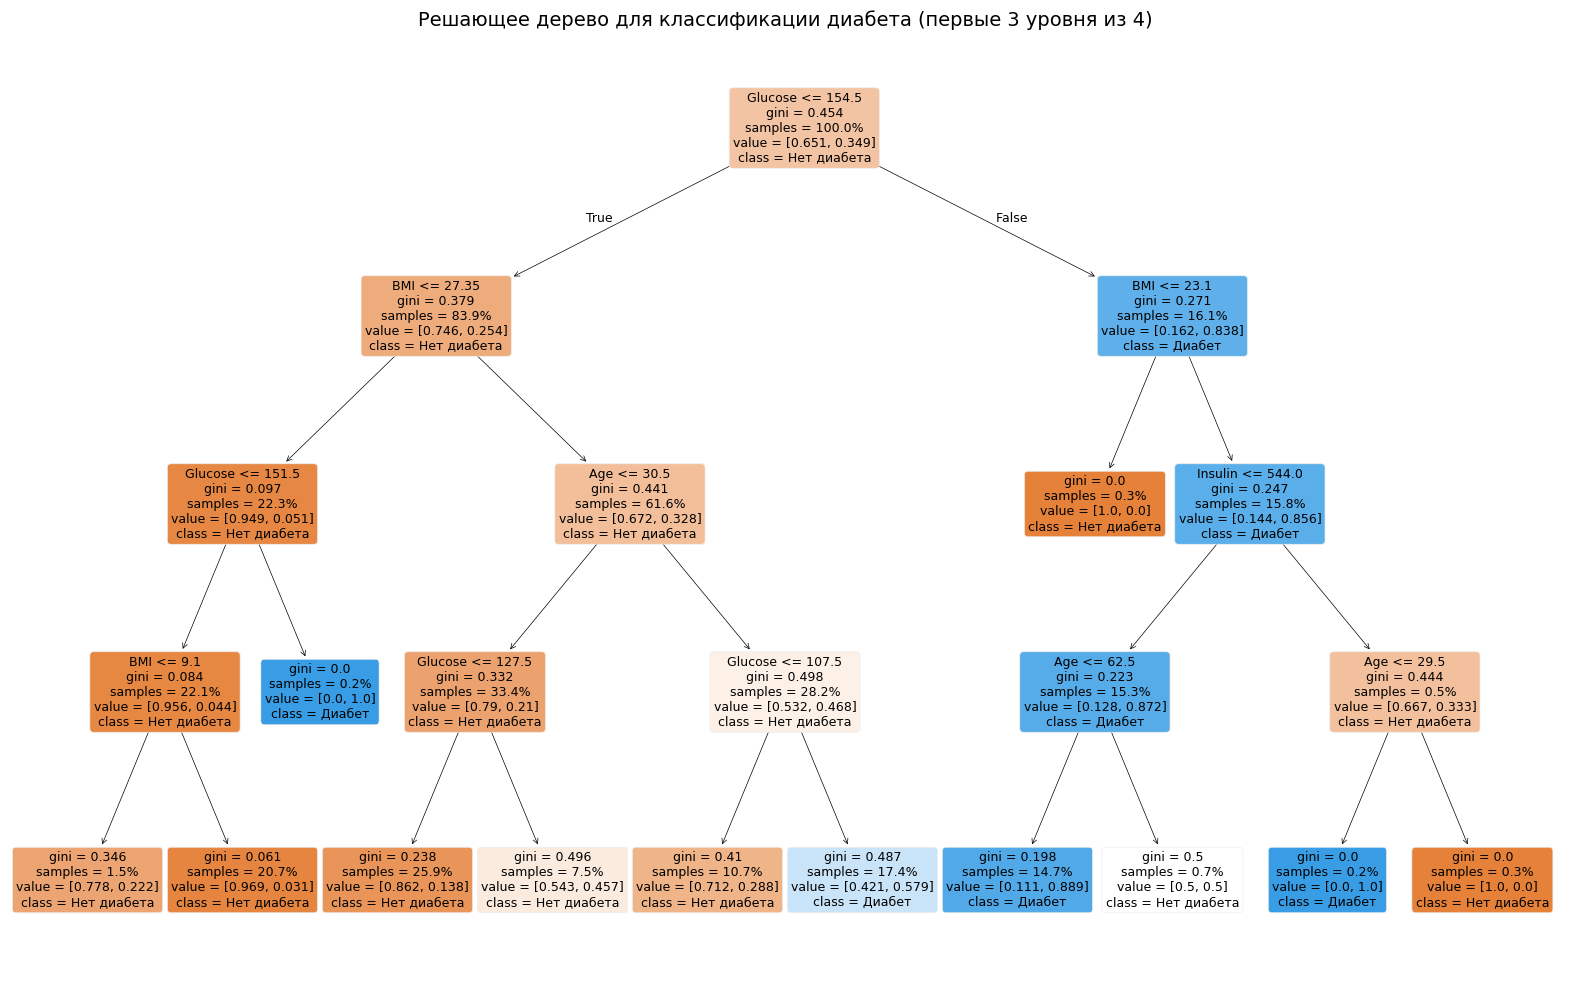

In [ ]:
# Визуализация дерева
plt.figure(figsize=(16, 10))
plot_tree(best_tree, 
          feature_names=features,
          class_names=['Нет диабета', 'Диабет'],
          filled=True, 
          rounded=True,
          fontsize=9,
          max_depth=4,
          proportion=True)
plt.title(f'Решающее дерево для классификации диабета', fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
# Важность признаков
importances = best_tree.feature_importances_
importance_df = pd.DataFrame({
    'Признак': features,
    'Важность': importances
}).sort_values('Важность', ascending=False)

print(importance_df.head().round(4).to_string(index=False))

    Признак  Важность
    Glucose    0.6709
        BMI    0.1747
        Age    0.1388
    Insulin    0.0156
Pregnancies    0.0000


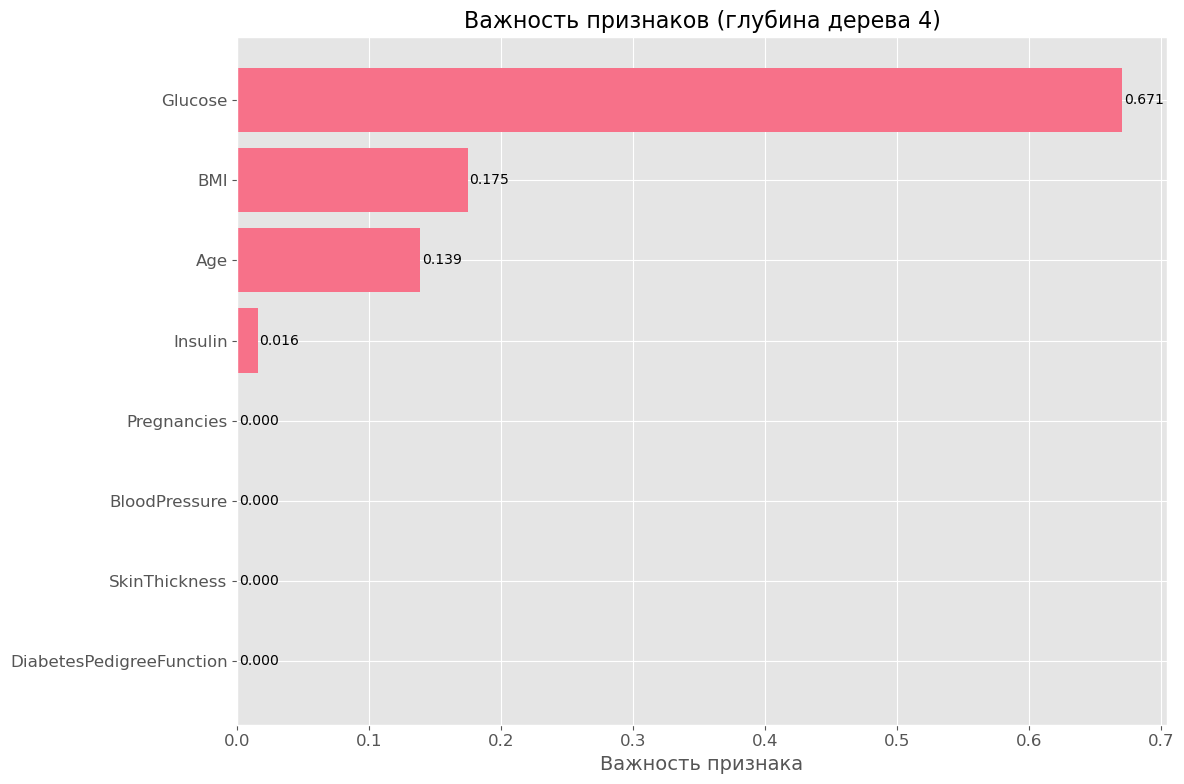

In [26]:
plt.figure(figsize=(12, 8))

bars = plt.barh(importance_df['Признак'], importance_df['Важность'])
plt.xlabel('Важность признака', fontsize=14)
plt.title(f'Важность признаков (глубина дерева {best_depth_test})', fontsize=16)
plt.gca().invert_yaxis()
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

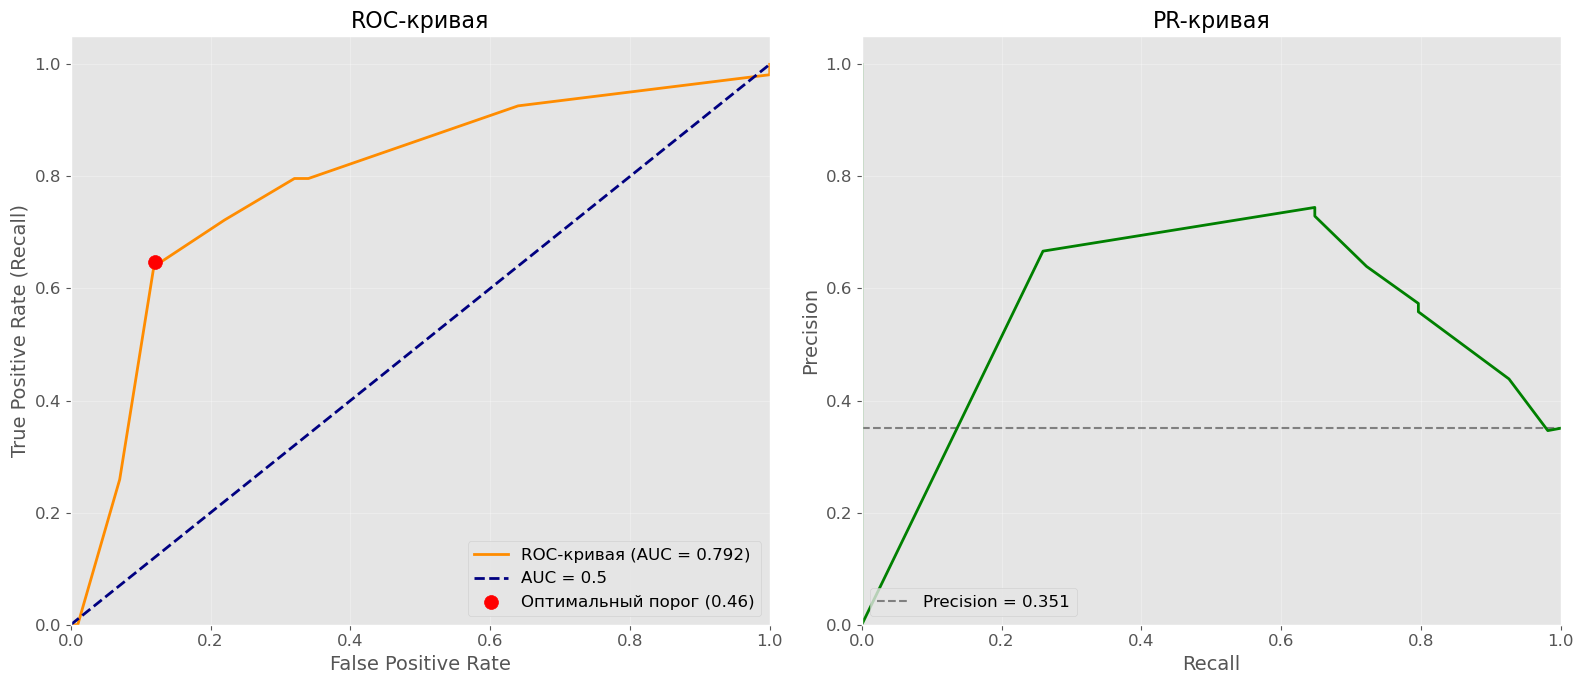

In [34]:
# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_best)
roc_auc = auc(fpr, tpr)

best_idx = auc_results_df['ROC-AUC (test)'].idxmax()

distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_idx_dist = np.argmin(distances)
best_threshold_dist = thresholds[best_idx_dist]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.5')
axes[0].scatter(fpr[best_idx], tpr[best_idx], color='red', s=100, zorder=5, label=f'Оптимальный порог ({best_threshold_dist:.2f})')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=14)
axes[0].set_title('ROC-кривая', fontsize=16)
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# PR-кривая
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_best)
avg_precision = average_precision_score(y_test, y_test_proba_best)

baseline = y_test.mean()
axes[1].axhline(y=baseline, color='gray', linestyle='--', label=f'Precision = {baseline:.3f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].set_title('PR-кривая', fontsize=16)
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)
axes[1].plot(recall, precision, color='green', lw=2, label=f'PR-кривая (AP = {avg_precision:.3f})')

plt.tight_layout()
plt.show()